In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

from os import getcwd
TRAIN = os.path.join(getcwd(), 'drive/MyDrive/Colab Notebooks/Assignment/Assignment3/MinHash/data/articles_1000.train')
TRUTH = os.path.join(getcwd(), 'drive/MyDrive/Colab Notebooks/Assignment/Assignment3/MinHash/data/articles_1000.truth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import string

In [ ]:
def parse_data(filename):
    if not filename:
        raise ValueError("filename is empty.")

    with open(filename) as f:
        # read lines from filename
        content = f.readlines()
        content = [x.strip() for x in content]
        exclude = set(string.punctuation)
        tuples = list()

    for line in content:
        id, article = line.split(" ", 1)

        #remove all punctuation
        #remove all whitespace so that all words are concatenated
        #change all letters to lowercase
        article = ''.join(ch for ch in article if ch not in exclude).replace(' ', '').lower()

        #construct tuple of id and text
        tuples.append((id, article))

    print(tuples[0:3])
    #return tuple with id and processed string
    return tuples

In [ ]:
import binascii

def shingle_document(string, k):
    if not string:
        raise ValueError("String is empty.")
    if not k:
        raise ValueError("k is empty.")

    # initialize set data structure
    unique_hash = set()

    # extract substring of length k
    # hash substring into 32-bit integer
    # insert into set
    for i in range(0, len(string) - k + 1):
        unique_hash.add(binascii.crc32(string[i:i+k].encode("utf-8")))

    # return set
    return unique_hash

In [ ]:
def jaccard(a, b):
    if not a:
        raise ValueError("a is empty.")
    if not b:
        raise ValueError("b is empty.")

    a = set(a)
    b = set(b)

    # compute union size
    # compute intersection size
    #return ratio of union and intersection
    return len(a.intersection(b))/len(a.union(b))

In [ ]:

def similarity(tuples, k):
    # if not filename:
    #     raise ValueError("filename is empty.")
    # if not k:
    #     raise ValueError("k is empty.")

    # parse a file with data
    # tuples = parse_data(filename)

    tuples_js = list()

    n = len(tuples)

    for i in range(0, n - 1):
        id_i, article_i = tuples[i]

        if k > len(article_i):
            raise ValueError("k is out of bound.")

        for j in range(i + 1, n):
            id_j, article_j = tuples[j]

            if k > len(article_j):
                raise ValueError("k is out of bound.")

            s = jaccard(shingle_document(article_i, k), shingle_document(article_j, k))
            tuples_js.append((id_i, id_j, s))

    # return a list of tuples, each tuple contains: (id1, id2, s)
    return tuples_js

In [ ]:
def average_Jaccard_similarity(train,p_truth,k):
    if not train:
        raise ValueError("train data is empty.")
    if not p_truth:
        raise ValueError("truth data is empty.")
    if not k:
        raise ValueError("n is empty.")
    # similarity
    js = similarity(train, k)

    # (id1, id2) is key, jaccard similarity is content.
    abbr_dict = {tuple(item[0:2]): item[2] for item in js}
    sum_train, sum_truth = 0, 0

    for j in range(0, len(p_truth)-1):
        # from dictionary we get js of key of (id1, id2)
        sum_truth = abbr_dict[(p_truth[j])] + sum_truth

    mean_truth = sum_truth/len(p_truth)

    for i in range(0, len(js)-1):
        sum_train = js[i][2] + sum_train

    # (sum of train js - sum of truth js)/# of js
    mean_train = (sum_train - sum_truth) / (len(js) - len(p_truth))

    #print(tuple((k, mean_train, mean_truth)))
    return tuple((k, mean_train, mean_truth))

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_mean_table(mean_table):
    df         = pd.DataFrame(mean_table)
    df.columns = ["k", "non-plagiarism instances", "plagiarism instances"]

    plt.plot('k', 'non-plagiarism instances', data = df, color = 'green')
    plt.plot('k', 'plagiarism instances',     data = df, color = 'red')

    plt.xlabel('k value')
    plt.ylabel('average Jaccard similarity')

    plt.title('Plagiarism and Non-Plagiarism Articles\'\nJaccard Similarity Comparison\n')
    plt.legend()
    plt.show()

    pass

In [ ]:
results = []
def results_log(msg):
    if(msg):
        results.append(msg)
        #print(msg)
    pass

[('t1088', 't5015'), ('t1297', 't4638'), ('t1768', 't5248')] 

[('t120', 'thesupremecourtinjohnnesbergonfridaypostponeduntilmarch14ahearingonapetitionbygovernmentministerwinniemandelatopreventpolicereadingdocumentsseizedfromherhomethesapanewsagencyreporteddavidwrightandcarlosdelgadohomeredandjorgesosawonforthesixthtimeasthenewyorkmetssnappedafourgamelosingstreakwitha30victoryoverdetroitonfridaynightusdefensesecretaryrobertgatessaidonsundaythatiranwasnotyetabletomakeanuclearweaponandthatitsprogramwasprogressingslowerthantehranexpectedapalestiniansuicidebomberblewhimselfupinacrowdedhoteldiningroomherewednesdayeveningjustasmorethan200peoplegatheredfortheirpassoverholidaymealkillingatleast19andwoundingmorethan100othersmanyofthemchildrenopeckingpinsaudiarabiasignalledtuesdayitcouldactalonetomeetapredictedincreaseindemandforoilasitpushedhesitantfellowmembersofthecarteltoraiseproductionquotasimmediatelythemostimportantformofpoliticalcompromiseiniraqisntamongtopiraqipoliticiansinbaghdadbutatth

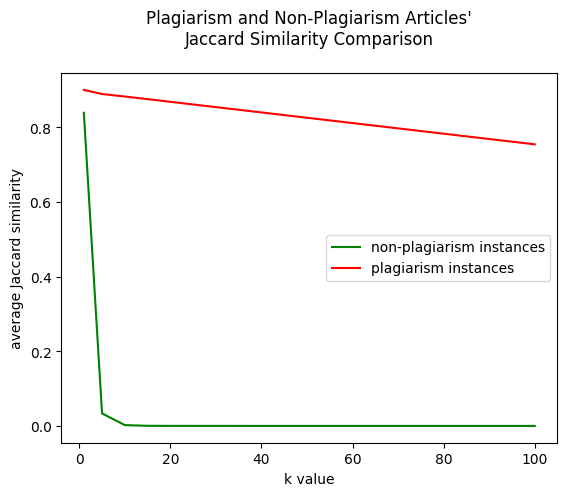

In [20]:
import multiprocessing  as mp

if __name__ == '__main__':
    # parse_data(), plagiarism truth is a pair of document ids
    p_truth = parse_data(TRUTH)
    train = parse_data(TRAIN)
    tuples  = list()

    #Make the most of CPU, parallel compute the similarity
    num_cores = int(mp.cpu_count())
    pool = mp.Pool(8)

    k_range = [1,5,10,15,20,40,60,80,100]
    # for k in k_range:
    #     tuples.append(average_Jaccard_similarity(TRAIN,p_truth,k))

    pool_results = [pool.apply_async(average_Jaccard_similarity,args=(train,p_truth,k) ,callback=results_log) for k in k_range]

    for i in pool_results:
        if(i.get()):
            tuples.append(i.get())

    #release sub-threads
    pool.close()
    pool.join()

    plot_mean_table(tuples)

#### What is the effect of sharding length k on the Jaccard similarity of plagiarism instances versus instances that are not plagiarized?

#### 1. When k is between 0 and 20, Jaccard similarity of non-plagirism decrease dramatically, after 20, and the trend of similarity of non-plagirism becomes smooth and approaching to 0.
#### 2. Jaccard similarity of plagiarism changes like linear and the effect on plagiarism is much smaller than non-plagirism one within the scope of length k.
#### 3. We do not need to choose a k bigger than 20, actually, in this train_1000 file, I consider 10 is the suitable k, because the similarity of non-plagiarism is appoaching to 0, and the plagirism one is 0.88. It reflects the truth well.